In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
import pandas as pd
from utils.img_transformation import Image
from utils.files_op import Files
import os
from pathlib import Path
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# PATHS
ROOT_DIR = Path('.')
DB_DIR = os.path.join(ROOT_DIR, 'database')

In [3]:
# Choose image directory here data augmentation was performed on the images
facials = ['hair_aug', 'nose_aug', 'lips_aug', 'eyes_aug', 'ears_aug', 'eyebrow_aug', 'faceshape_aug', 'eyes_aug', 'jaw_aug']

IN_SIZES = 128
IN_SIZE = (IN_SIZES, IN_SIZES)
database = 'database'
# Image directory of facial feature images (data augmented images)
facial = 'nose_aug'
train_path = f'{database}//{facial}'
split = 0.2

In [6]:
train_path

'database//nose_aug'

In [4]:
train_images = []
train_labels = [] 
for directory_path in glob.glob(train_path + '/*'):
#     print('dir', directory_path)
    label = directory_path.split("/")[-1]
#     print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
#         print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, IN_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        train_images.append(img)
        train_labels.append(label)
        
t_images = np.array(train_images)
t_images = np.expand_dims(t_images, axis=-1)
t_labels = np.array(train_labels)



In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(t_images,t_labels, test_size=split, random_state=42)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
n_classes = len(np.unique(t_labels))
# print('n_classes : ', n_classes)
print(np.unique(t_labels))

In [6]:
import tensorflow as tf

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers

In [8]:
model1 = tf.keras.Sequential([
   tf.keras.layers.AveragePooling2D(6,3, input_shape=(IN_SIZES,IN_SIZES,1)),
   tf.keras.layers.Conv2D(64, 3, activation='relu'),
   tf.keras.layers.Conv2D(32, 3, activation='relu'),
   tf.keras.layers.MaxPool2D(2,2),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(n_classes, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model1.fit(x_train, y_train_one_hot, epochs=40, validation_data = (x_test, y_test_one_hot), batch_size=32)

[2022-01-12 13:04:36.050 ip-172-16-13-169:17794 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-12 13:04:36.085 ip-172-16-13-169:17794 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 2173 samples, validate on 544 samples
Epoch 1/40
2173/2173 [==============================] - 3s 1ms/sample - loss: 1.9768 - accuracy: 0.2826 - val_loss: 1.7219 - val_accuracy: 0.3658
Epoch 2/40
2173/2173 [==============================] - 1s 384us/sample - loss: 1.4649 - accuracy: 0.4722 - val_loss: 1.4664 - val_accuracy: 0.4540
Epoch 3/40
2173/2173 [==============================] - 1s 386us/sample - loss: 1.2808 - accuracy: 0.5366 - val_loss: 1.3459 - val_accuracy: 0.5147
Epoch 4/40
2173/2173 [==============================] - 1s 387us/sample - loss: 1.1257 - accuracy: 0.5854 - val_loss: 1.2494 - val_accuracy: 0.5460
Epoch 5/40
2173/2173 [==============================] - 1s 386us/sample - loss: 1.0286 -

In [11]:
model1.save(f'light_{facial}.h5')

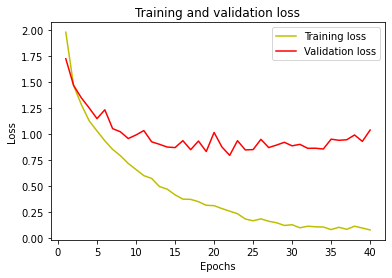

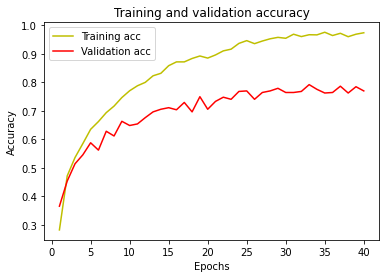

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

544


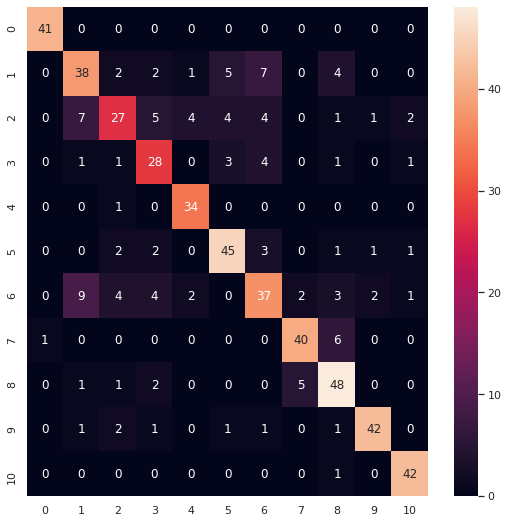

In [12]:
prediction_NN = model1.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
sns.set(rc = {'figure.figsize':(9,9)})
sns.heatmap(cm, annot=True)
print(len(test_labels))


In [14]:
print(np.unique(t_labels))

['00_BALD' '03_BUN' '10_MOHAWK' '11_PIXIECUT_STRAIGHT' '12_PIXIECUT_COILY'
 '13_PIXIECUT_WAVY' '14_PONYTAIL' '15_SHAVED' '16_PIXIECUT_COILY_CURLY'
 '17_PIXIECUT_STRAIGHT' '18_PIXIECUT_WAVY']


In [15]:
#Now, let us use features from convolutional network for RF
model_feats = Model(inputs=model1.inputs, outputs=model1.layers[-2].output)


feature_extractor=model_feats.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF


#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = model_feats.predict(x_test)

X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [16]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.75


Prediction:  ['16_PIXIECUT_COILY_CURLY']
Current:  16_PIXIECUT_COILY_CURLY


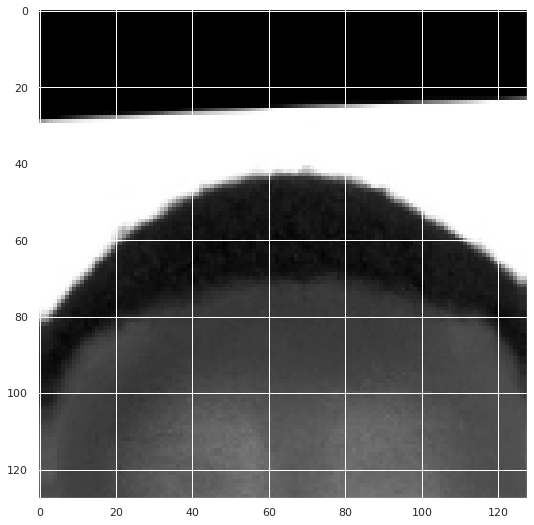

In [32]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img, cmap='gray')
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model_feats.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RFr = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("Prediction: ", prediction_RFr)
print("Current: ", test_labels[n])